In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpyro

NDEVICES = 4 
numpyro.set_host_device_count(NDEVICES)

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/01_2024_filecoin_forecasts')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [5]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=60) # get some historical data
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

2023-11-06 2024-01-05 2026-01-04


In [17]:
pystarboard.data.setup_spacescope(token)

In [6]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

In [7]:
@disk_utils.cache_data(directory=offline_info_dir)
def get_historical_onboarding_data():
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365), current_date)
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365), current_date)
    # day_vec = np.arange(0,len(hist_fpr))
    return {
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr,
    }
x = get_historical_onboarding_data()
locals().update(x)

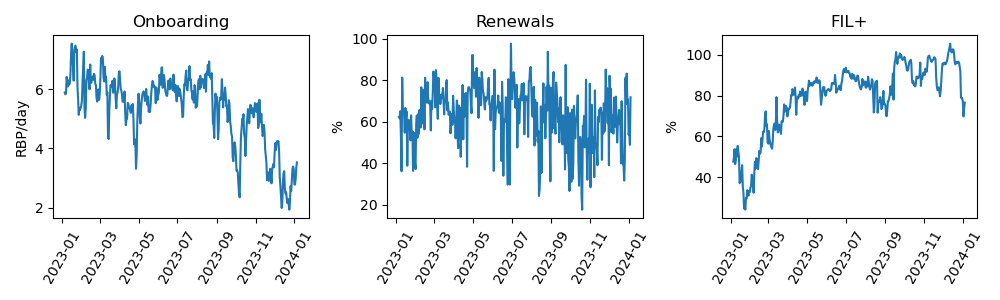

In [11]:
# plot historical trends
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)

axx = ax[0]
axx.plot(t_hist_rbp, hist_rbp)
axx.set_title('Onboarding')
axx.set_ylabel('RBP/day')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
axx = ax[1]
axx.plot(t_hist_rr, hist_rr*100)
axx.set_title('Renewals')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(t_hist_fpr, hist_fpr*100)
axx.set_title('FIL+')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()

In [12]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [18]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr, deal_onboard_pred_rhats, cc_onboard_pred_rhats = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
        'deal_onboard_pred_rhats':deal_onboard_pred_rhats, 
        'cc_onboard_pred_rhats': cc_onboard_pred_rhats
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics
    
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=False)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred': renewal_rate_pred,
        'filplus_rate_pred': filplus_rate_pred,
        'historical_rb_date': historical_rb_date,
        'historical_rb': historical_rb,
        'historical_rr_date': historical_rr_date,
        'historical_rr': historical_rr,
        'historical_fpr_date': historical_fpr_date,
        'historical_fpr': historical_fpr,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
exp_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])

print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
print('Expirations Forecast RHat < 1.05: %0.02f %%' % (exp_rhat_check*100,))

Forecasting Onboarding Power
Forecasting Renewal Rate
Forecasting FIL+ Rate
RBP Forecast RHat < 1.05: 100.00 %
Extensions Forecast RHat < 1.05: 65.61 %
Expirations Forecast RHat < 1.05: 99.47 %
